In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import torch
from torch import nn
from torch import optim
import os

In [3]:
NUM_CLIENTS = 10

from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def carregar_dados(train_data,test_data):
  train_data = pd.read_csv(train_data)
  val_data = pd.read_csv(test_data)

  X_train = train_data.drop(['hysteresis', 'joule'], axis=1)
  y_train = train_data[['hysteresis', 'joule']]

  X_val = val_data.drop(['hysteresis', 'joule'], axis=1)
  y_val = val_data[['hysteresis', 'joule']]

  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_val_scaled = scaler.transform(X_val)

  X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
  y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

  X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
  y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

  return X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor

In [10]:
import matplotlib.pyplot as plt
import torch
def plot_comparacao(y_true, y_pred):

    plt.figure(figsize=(8, 6))

    # Plot each target separately
    for i in range(2):  # Assuming two targets
        plt.scatter([true[i] for true in y_true], [pred[i] for pred in y_pred], label=f'Target {i+1}', alpha=0.5)

    max_val = max(max(y_true[:,0]), max(y_pred[:,0]), max(y_true[:,1]), max(y_pred[:,1]))
    plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', linewidth=2, label='Reference Line')

    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('Comparison between True and Predicted Values')
    plt.legend()

    plt.show()


In [5]:
class tenlayersNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(tenlayersNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 200)
        self.fc2 = nn.Linear(200, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 64)
        self.fc6 = nn.Linear(64, 64)
        self.fc7 = nn.Linear(64, 64)
        self.fc8 = nn.Linear(64, 64)
        self.fc9 = nn.Linear(64, 32)
        self.fc10 = nn.Linear(32, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.relu(self.fc6(x))
        x = self.relu(self.fc7(x))
        x = self.relu(self.fc8(x))
        x = self.relu(self.fc9(x))
        x = self.fc10(x)
        return x


In [6]:

def load_model(filename, model_class, input_size, output_size):
    print("Carregando modelo...")
    checkpoint = torch.load(filename)

    model = model_class(input_size, output_size)

    model.load_state_dict(checkpoint['state_dict'])

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    optimizer.load_state_dict(checkpoint['optimizer'])

    return model, optimizer

def save_model(state,filename="Saved_Model.pth"):
  print("salvando modelo...")
  torch.save(state,filename)

def train(model,num_epochs,optimizer):
  criterion = nn.MSELoss()
  for epoch in range(num_epochs):
      optimizer.zero_grad()
      outputs = model(X_train_tensor)
      loss = criterion(outputs, y_train_tensor)
      loss.backward()
      optimizer.step()

      if (epoch+1) % 100 == 0:
          print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


def test(model):
  model.eval()
  criterion = nn.MSELoss()
  with torch.no_grad():
      predicted = model(X_val_tensor)
      test_loss = criterion(predicted, y_val_tensor)
      print(f'Test Loss: {test_loss.item():.4f}')
  return predicted


In [7]:
folder_path = '/content/drive/MyDrive/FederatedLearning-main/Data/IPMSM_datasets/dataset_for_iron_losses_of_IPMSMs/V'
os.chdir(folder_path)

X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor = carregar_dados('dados_de_treino.csv','dados_de_teste.csv')
input_size = X_train_tensor.shape[1]
print(input_size)
output_size = y_train_tensor.shape[1]
print(output_size)
modelV = tenlayersNetwork(input_size, output_size)
optimizer = optim.Adam(modelV.parameters(), lr=0.001)

6
2


In [8]:
train(modelV,2000,optimizer)

modeltosave = {'state_dict': modelV.state_dict(),'optimizer':optimizer.state_dict()}
save_model(modeltosave)

Epoch [100/2000], Loss: 0.0531
Epoch [200/2000], Loss: 0.0326
Epoch [300/2000], Loss: 0.0263
Epoch [400/2000], Loss: 0.0236
Epoch [500/2000], Loss: 0.0222
Epoch [600/2000], Loss: 0.0210
Epoch [700/2000], Loss: 0.0207
Epoch [800/2000], Loss: 0.0203
Epoch [900/2000], Loss: 0.0202
Epoch [1000/2000], Loss: 0.0202
Epoch [1100/2000], Loss: 0.0204
Epoch [1200/2000], Loss: 0.0195
Epoch [1300/2000], Loss: 0.0197
Epoch [1400/2000], Loss: 0.0195
Epoch [1500/2000], Loss: 0.0192
Epoch [1600/2000], Loss: 0.0191
Epoch [1700/2000], Loss: 0.0187
Epoch [1800/2000], Loss: 0.0190
Epoch [1900/2000], Loss: 0.0185
Epoch [2000/2000], Loss: 0.0187
salvando modelo...


Test Loss: 0.0231


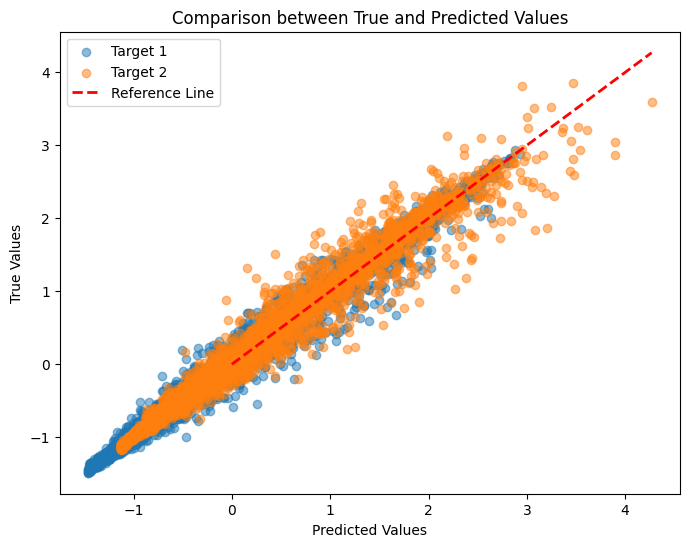

In [11]:
plot_comparacao(y_val_tensor,test(modelV))

In [ ]:
new_modelVnabla, new_optimizernabla = load_model("Saved_Model.pth", tenlayersNetwork,input_size,output_size)
new_modelV2d, new_optimizer2d = load_model("Saved_Model.pth", tenlayersNetwork,input_size,output_size)

In [ ]:
folder_path = '/content/drive/MyDrive/FederatedLearning-main/Data/IPMSM_datasets/dataset_for_iron_losses_of_IPMSMs/Nabla'
os.chdir(folder_path)

X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor = carregar_dados('dados_de_treino.csv','dados_de_teste.csv')
input_size = X_train_tensor.shape[1]
output_size = y_train_tensor.shape[1]

In [ ]:
new_modelVnabla.fc1 = nn.Linear(input_size, 200)
plot_comparacao(y_val_tensor,test(new_modelVnabla))

In [ ]:
folder_path = '/content/drive/MyDrive/FederatedLearning-main/Data/IPMSM_datasets/dataset_for_iron_losses_of_IPMSMs/2D'
os.chdir(folder_path)

X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor = carregar_dados('dados_de_treino.csv','dados_de_teste.csv')
input_size = X_train_tensor.shape[1]
output_size = y_train_tensor.shape[1]

In [ ]:
new_modelV2d.fc1 = nn.Linear(input_size, 200)
plot_comparacao(y_val_tensor,test(new_modelV2d))